In [14]:
import random
import sys
import os
import types
import torch
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import random
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import PIL
from torch.autograd import Variable
from tqdm.notebook import tqdm
from ipywidgets import IntProgress
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

import cv2

from lime import lime_image
from skimage.segmentation import mark_boundaries

from models import DenseNet121


In [15]:
train_csv_path = '/home/tu-serbin/data/chexpert/v1.0/train.csv'
valid_csv_path = '/home/tu-serbin/data/chexpert/v1.0/valid.csv'
model_save_dir = '/home/tu-serbin/group/igloo/alex/saves/'
dir_path = '/home/tu-serbin/data/chexpert/v1.0/'
data_path = '/home/tu-serbin/data/'



## Data preparation

In [16]:
#function which drops lateral image records and irrelevant columns, replaces -1 with 0, corrects Path column

def dropper(df):
    d = df.copy()
    index = d[d["Frontal/Lateral"] == "Lateral"].index
    d.drop(index=index, axis=0, inplace=True)
    d = d.drop(columns=['Sex','Age','Frontal/Lateral','AP/PA'])
    #d = d.replace(-1.0,0)
    d.Path = d.Path.str.replace('CheXpert-','chexpert/')
    d = d.reset_index(drop=True)
    return d

In [17]:
valid_csv = pd.read_csv(valid_csv_path, sep=',').fillna(0)
dval = dropper(valid_csv)

train_csv = pd.read_csv(train_csv_path, sep=',').fillna(0)
dtrain = dropper(train_csv)

index_ = dval.sum().drop('Path') < 5
bad_cols = dval.drop(columns='Path').columns[index_.to_list()]
good_cols = dval.columns.drop(bad_cols.to_list()+['Path'])

# image paths Series
vpath = dval.Path#.str.replace('CheXpert-','chexpert/')
tpath = dtrain.Path#.str.replace('CheXpert-','chexpert/')

## Transforms

In [18]:
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

dnet_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    
])

In [19]:
# image loader by index
def get_im(k):
    image = Image.open(os.path.join(data_path, tpath.iloc[k])).convert('RGB')
    print(tpath.iloc[k])
    #print(valid_csv.loc[k,'Path'])
    return image

dnet = DenseNet121(14)
load1 = torch.load(model_save_dir+'epoch_1_score_0.81652.pth', map_location='cpu')
dnet.load_state_dict(load1['state_dict'])


for CAM

fmodel = dnet.net.features
weights = list(fmodel.parameters())[-2]
_=dnet.eval()


In [20]:
# receives a binary vector and outputs 1d array with indexes of elements which are ones

def findings(z, beta=0.3):

    # assume z is a tensor 
    if type(z) != np.ndarray:
        y = z.squeeze().numpy()
        #print('shape',y.shape)
    else:
        y = z.copy().squeeze()
        #print(y)

    idx = np.argwhere(y > beta)

    if idx.ndim > 1:
        idx = idx.squeeze()
    
    
    if idx.ndim == 0:
        idx = np.expand_dims(idx,0)
        #print(type(idx),[idx])
    return idx

## Class for generating LIME images
parameter num_samples can be varied. bigger value leads to better accuracy but takes longer to compute (num_samples=1000 ~ 1.5 minutes)

In [21]:
class LimeExp():
    def __init__(self, mod):
        self.model = mod
        
    def explain_please(self, im:Image.Image, transform=None, cuda=False):
        im_r = im
        self.c = cuda
        if transform:
            im_r = transform(im_r)
        self.model.eval()     
              
        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(np.transpose(im_r.numpy(),(1,2,0)).astype(np.double), #resized image as numpy array 
                                         self.predictor, # classification function
                                         top_labels=3, 
                                         hide_color=0, 
                                         num_samples=100) # number of images that will be sent to classification function
        return explanation
    
    # efnet and ensnet can only take few images so bath size has to be modified
    def predictor(self, im:np.array):
        #from IPython.core.debugger import Tracer; Tracer()() 
        l = im.shape[0]

        im1 = np.transpose(im, (0,3,1,2))
        im1 = torch.Tensor(im1)
        
        #if efnet or ensnet then use gpu and run 1 sample at a time
        
        if self.c: 
            im1 = im1.cuda()
            self.model.cuda()
            
            logits = torch.Tensor([]).cuda()
            for i in im1:
                tmp = self.model(i.unsqueeze(0))
                logits = torch.cat((logits, tmp),0)
        else:
            logits = self.model(im1)

        
        probs = F.softmax(logits, dim=1)
        return probs.cpu().detach().numpy()
    

### GradCAM

In [22]:
tmpgrads = []
args1 = []

def actmap(model, image_orig, transform, true_labels):
    global tmpgrads, args1 
    tmpgrads = []
    print('Computing gradCAM')
    #stored_grads1 = 0
    #stored_fpass1 = 0
    
    def bpass_hook(self, gin, gout):
        global stored_grads1
        stored_grads1 = gout
        #print('stored_grads1 hook \n',stored_grads1)

        #print('Backward hook called.')
        #print(gout)
            
    def fpass_hook(self, ten_in, ten_out):
        global stored_fpass1
        stored_fpass1 = ten_out
            
    # register hooks
    last_conv = model.net.features.denseblock4.denselayer16.conv2
    handle_b = last_conv.register_backward_hook(bpass_hook)
    handle_f = last_conv.register_forward_hook(fpass_hook)
    
    #from IPython.core.debugger import Tracer; Tracer()() 

    # get image and true labels
   
    trim = transform(image_orig).unsqueeze(0)

    true_labels_pos = np.argwhere(true_labels==1).flatten()
    true_labels_uncertain = np.argwhere((-1)*true_labels==1).flatten()
    
    # run model
    out = model(trim)
    out_np = out.detach().numpy().squeeze()
    pred_labels = findings(out_np, beta=0.5)
    if pred_labels.shape[0]==0:
        pred_labels = [out_np.argmax()]
    pred_labels_p = np.round(out_np[pred_labels], 2)
    
    # generate argument vectors for backward() function.
    # generate as many as there are predicted classes with p>0.5 (implemented in function 'findings')

    l = len(pred_labels)
    args1 = []
    for ii in pred_labels:
        backward_arg = torch.zeros(1,14)
        backward_arg[0,ii] = 1
        args1.append(backward_arg)
    
    # generate gradCAMs and plot them
    
    hmap_list = []
    cam_list = []
    plt_titles = []
    
    img_hmap = np.transpose(trim.squeeze().numpy(),(1,2,0))

    arglen = len(args1)
    kwargs = dict(xticks=[],yticks=[])

    #fig, ax = plt.subplots(1, arglen, figsize=(5*arglen,5), subplot_kw=kwargs)
    #if arglen==1:
    #    ax = [ax]
    #plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    #print('stored_grads1\n',stored_grads1)
    for k, a in enumerate(args1):
        print('{}/{}'.format(k+1,arglen))
        #from IPython.core.debugger import Tracer; Tracer()() 
        out.backward(a, retain_graph=True)
        
        #print('stored_grads11\n',stored_grads1)
        gradients = stored_grads1[0].clone()
        tmpgrads.append(stored_grads1)
        activations = stored_fpass1[0].clone().unsqueeze(0)
        activations = activations.detach()

        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

        for j in range(gradients.shape[1]):
            activations[:, j, :, :] *= pooled_gradients[j]

        heatmap = torch.sum(activations, dim=1).squeeze()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= torch.max(heatmap)

        hmap_list.append(heatmap)

        #ax.flatten()[k].imshow(heatmap)


        hmap = heatmap.numpy()
        heatmap1 = cv2.resize(hmap, (img_hmap.shape[1], img_hmap.shape[0]))
        heatmap1 = np.uint8(-255 * heatmap1 + 255)
        heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)

        supim = heatmap1 * 0.002 + img_hmap
        supim = supim / supim.max()

        cam_list.append(supim)
        plt_titles.append(dtrain.columns[1:][pred_labels[k]])
        #ax[k].imshow(supim)
        #ax[k].set_title(dtrain.columns[1:][pred_labels[k]])
        #Tracer()() 

    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('True labels:', true_labels_pos, dtrain.columns[1:][true_labels_pos].to_list())
    print('Uncertainties:', true_labels_uncertain, dtrain.columns[1:][true_labels_uncertain].to_list())
    print('Prediction:', pred_labels, dtrain.columns[1:][pred_labels].to_list())
    print('Probabilities:', pred_labels_p)
    
    return cam_list, plt_titles

## Class for generating gradCAM and LIME

In [23]:
#keep gen_gcam function here until all test are ok

class EGenerator():
    
    def __init__(self, save_path='/home/tu-serbin/group/igloo/alex/CAMs/Compound/'):
        # instantiate models and transforms
        # dataframe with index Path and the diseases as columns; len = 14
        #self.df = csv
        self.save_path = save_path
        self.init_models()
        self.init_transforms()
    
    # currently takes path!
    def run_dnet(self, impath, true_labels = None):
        ''' impath : path to image
            outpath (optional) : save path
            true_labels : binary array of length 14
        '''       
        
        cmodel = self.dnet
        ctrans = self.dnet_transform
        # c stands for 'current'
            
        image = Image.open(impath).convert('RGB')
        im_tr = ctrans(image).unsqueeze(0)
        
        pred = cmodel(im_tr)
            
        pred_txt = pred.detach().cpu().data.numpy().squeeze()
        pred_txt = np.around(pred_txt,2)
        
        # from IPython.core.debugger import Tracer; Tracer()() 
        
        # gradCAM for densenet
        #gc_res = cams.gen_gcam(image, ctrans, 224, self.weights_dnet, self.feat_dnet)
        cams, titles = actmap(cmodel, image, ctrans, true_labels)
        # place for other methods
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # łime
        lime_res = self.run_lime(image, cmodel, ctrans)
        lime_plot_label = dtrain.columns[1:][pred_txt.argmax()]
        
        
        cams.append(lime_res)
        titles.append(lime_plot_label)
        # now plot!
        #caption = self.to_txt(impath[20:], 'Prediction:', pred_txt, 'True labels:', true_labels)
        self.plots(cams, titles)
        
        
        
    def run_lime(self, image, mod, trans):
        print('Computing LIME')
        lime_ = LimeExp(mod)
        exp = lime_.explain_please(image, trans, cuda=False)
        temp, mask = exp.get_image_and_mask(exp.top_labels[0], positive_only=False, num_features=10,\
                                            hide_rest=False)
        img_boundry1 = mark_boundaries(temp, mask)
        return img_boundry1
      
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    def init_models(self):
        # instantiate models and load state_dict's
        self.dnet = DenseNet121(14)
    
        self.feat_dnet = self.dnet.net.features
        self.weights_dnet = list(self.feat_dnet.parameters())[-2]
        self.dnet.eval()
        
        load1 = torch.load(model_save_dir+'epoch_1_score_0.81652.pth', map_location='cpu')
        self.dnet.load_state_dict(load1['state_dict'])
        self.dnet.eval()
        
        
    def init_transforms(self):
        self.dnet_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
   
    # stacks strings from argument list
    def to_txt(self, *args):
        res = ''
        for i in args:
            res += str(i)+' \n'
            
        return res
        
    # plot images with text
    # currently supported shape is 2x2
    def plots(self, cams, titles):
        l = len(cams)
        fig, ax = plt.subplots(1,l, figsize=(5*l,5), subplot_kw={'xticks':[], 'yticks':[]})
        
        for i,a in enumerate(ax.flatten()):
            a.imshow(cams[i])
            a.set_title(titles[i])
        
        
        '''save_name = save_name.replace('/','-')
        fig, ax = plt.subplots(2,2, figsize=(17,17), subplot_kw={'xticks':[], 'yticks':[]})
        axs = ax.flatten()
        
        axs[0].imshow(origim)
        axs[2].text(0.5,0.5, text, transform=axs[2].transAxes,
            horizontalalignment='center',
           fontsize=16)
        axs[2].axis('off')
        axs[1].imshow(cam1)
        axs[3].imshow(cam2)'''
        
        #plt.savefig(self.save_path + save_name)
        #print('Generated image is saved as: \n', self.save_path+save_name)

In [24]:
dnet = DenseNet121(14)
#load1 = torch.load(model_save_dir+'epoch_1_score_0.81652.pth', map_location='cpu')
#dnet.load_state_dict(load1['state_dict'])

eggen = EGenerator()

## Fetch random image  and run gradCAM + LIME
pick random entry from dtrain DataFrame and use explanation methods on corresponding picture

In [25]:
imid = np.random.randint(dtrain.shape[0])
path1 = data_path+dtrain.Path.iloc[imid]

true_labels = dtrain.iloc[imid,1:].to_numpy().astype(int)
print('Sampled image is: \n',path1)

Sampled image is: 
 /home/tu-serbin/data/chexpert/v1.0/train/patient22709/study8/view1_frontal.jpg


Computing gradCAM
1/2
2/2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 3 10 13] ['Lung Opacity', 'Pleural Effusion', 'Support Devices']
Uncertainties: [6 8] ['Consolidation', 'Atelectasis']
Prediction: [10 13] ['Pleural Effusion', 'Support Devices']
Probabilities: [0.65 0.7 ]
Computing LIME


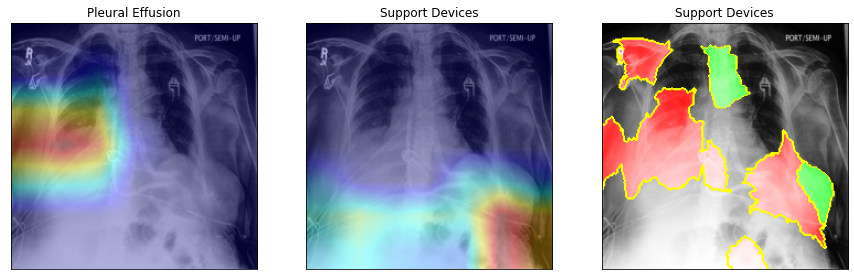

In [26]:
im8 = eggen.run_dnet(path1, true_labels=true_labels)